# Aprendizaje Automatico - Trabajo Practico 1

Para comenzar debemos seleciconar el entorno donde correr esta notebook, ya sea **Google Colab** o **Jupyter** (Local). Si elegimos la opcion local, es necesario instalar dependencias (Modulos de python) usando el gestor de dependencias/entornos **conda**(o mamba). Para esto últimos, se puede ver el [Readme](https://github.com/magistery-tps/aa-tp1) en el repositorio. 
En caso que querer correr esta notebook en **Google Colab**, solo es necesario importar la misma en **Colab** y dejar comentada la linea `ENV = 'jupyter'` a continuación:

Seleccionemos **Colab**:

In [64]:
ENV = 'colab'
ENV = 'jupyter'

In [65]:
if 'colab' in ENV:
  !pip install --upgrade matplotlib

**Nota**: Para el caso de **Colab** luego de instalar la libreria **matplotlib** es necesario reiniciar el environment.

Importamos los modulos necesarios:

In [66]:
import warnings
warnings.filterwarnings('ignore')

from dataclasses import dataclass

import numpy   as np
import pandas  as pd

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image  as mpimg
from   six               import StringIO  
from   IPython.display   import Image
import pydotplus

from sklearn.experimental    import enable_iterative_imputer
from sklearn.model_selection import train_test_split, StratifiedKFold, \
                                    RandomizedSearchCV
from sklearn.impute          import IterativeImputer
from sklearn.preprocessing   import OneHotEncoder
from sklearn.tree            import DecisionTreeClassifier, export_graphviz
from sklearn.metrics         import accuracy_score, confusion_matrix, \
                                    plot_confusion_matrix, \
                                    f1_score, precision_score, \
                                    recall_score, make_scorer, fbeta_score, \
                                    classification_report, roc_curve
from sklearn.feature_selection import RFECV

from imblearn.over_sampling    import SMOTENC
from imblearn.under_sampling   import RandomUnderSampler
from imblearn.pipeline         import Pipeline

Configuración común para todas las gráficas:

In [67]:
sns.set_style("white")
sns.despine()

tiny_size   = lambda: sns.set(rc={'figure.figsize':(5,5)})
normal_size = lambda: sns.set(rc={'figure.figsize':(13, 8)})
big_size    = lambda: sns.set(rc={'figure.figsize':(20,5)})

<Figure size 936x576 with 0 Axes>

## Pasos

#### A) A partir de los datos entregados, describir los atributos realizando una breve explicación de qué representan y del tipo de variable (categórica, numérica u ordinal). En caso de que haya variables no numéricas, reportar los posibles valores que toman y cuán frecuentemente lo hacen.

In [68]:
#
# Funciones utilizadas para mostrar un resumen de cada variable numerica o categorica.
#

def histplot(df, column):
    f, (ax_box, ax_hist) = plt.subplots(
        2, 
        sharex=True, 
        gridspec_kw= {"height_ratios": (0.2, 1)}
    )
    mean=df[column].mean()
    median=df[column].median()
    mode=df[column].mode().values[0]

    sns.boxplot(data=df, x=column, ax=ax_box)
    ax_box.axvline(mean,   color='r', linestyle='--')
    ax_box.axvline(median, color='g', linestyle='-')
    ax_box.axvline(mode,   color='b', linestyle='-')

    sns.histplot(data=df, x=column, ax=ax_hist, kde=True)
    ax_hist.axvline(mean,   color='r', linestyle='--', label="Media")
    ax_hist.axvline(median, color='g', linestyle='-',  label="Mediana")
    ax_hist.axvline(mode,   color='b', linestyle='-',  label="Moda")

    ax_hist.legend()

    ax_hist.set_title(f'Histograma - {column}')
    ax_hist.set(ylabel='Frecuencia')
    ax_hist.set(xlabel='Valores')
    
    ax_box.set_title(f'Boxplot - {column}')
    ax_box.set(xlabel='')
    
    plt.show()

def describe_num_var(df, column):
    df_column = df[[column]]
    column_range = (min(df_column.values)[0], max(df_column.values)[0])
    print(f'\nRango: {column_range}\n')  

    normal_size()
    histplot(df, column)

    print('\nMetricas:\n')
    display(df_column.describe())

def array_num_to_str(numbers): return [str(n) for n in numbers]
    
def describe_cat_var(df, column):
    grouped_by_value = df[column].value_counts()
    
    print('\nPosibles Valores:', ', '.join(array_num_to_str(grouped_by_value.index.values)) + '.')
    print('\nHistograma:')

    tiny_size()
    sns.histplot(data=df, y=column)
    plt.ylabel('Valores')
    plt.xlabel('Frecuencia')
    plt.title(f'Histograma - {column}')
    plt.show()
    
    print(f'\nTabla de frecuencias:\n')
    display(grouped_by_value)

Cargamos el dataset:

In [69]:
if 'colab' in ENV:
    from google.colab import files
    uploaded = files.upload()
    dataset = pd.read_csv('./healthcare-dataset-stroke-data.csv')
else:
    dataset = pd.read_csv('../dataset/healthcare-dataset-stroke-data.csv')

In [70]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


Antes que nada, redefinimos el tipo de la columnas categoricas, ya que hay variables con tipos numericos que para nuestro analisis son categoricas:

In [71]:
CAT_COLUMNS = [
    'gender', 
    'hypertension', 
    'heart_disease', 
    'ever_married',
    'work_type', 
    'Residence_type', 
    'smoking_status'
]
NUM_COLUMNS = ['age', 'avg_glucose_level', 'bmi', 'stroke']

In [72]:
class ColumnFormater:
    """
    Utilidad para definir el tipo de cada columnas del dataset a analizar.
    """
    def __init__(self, categorical_columns, num_columns):
        self.categorical_columns = categorical_columns
        self.num_columns = num_columns

    def format(self, df):
        for col_name in df.columns: 
            if col_name in self.categorical_columns:
                df[col_name] = df[col_name].apply(str)
            elif col_name in self.num_columns:
                df[col_name] = df[col_name].astype(float)
        return df

class ColumnFormaterFactory:
    @staticmethod
    def default(): return ColumnFormater(CAT_COLUMNS, NUM_COLUMNS)

Definimos los tipos de cada variable según sea numerica(float64) o categorica(object):

In [73]:
dataset = ColumnFormaterFactory.default().format(dataset)

dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   object 
 4   heart_disease      5110 non-null   object 
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 479.2+ KB


#### Analisis univariado

#### Genero

Es una variable categorica con los siguentes posibles valores:


Posibles Valores: Female, Male, Other.

Histograma:


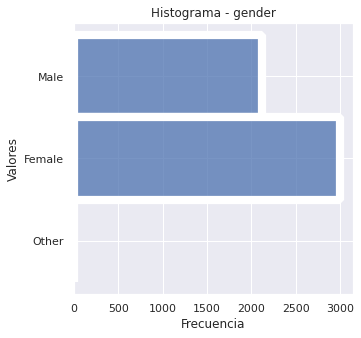


Tabla de frecuencias:



Female    2994
Male      2115
Other        1
Name: gender, dtype: int64

In [74]:
describe_cat_var(dataset, 'gender')

#### Edad

Es una variable numerica con decimales. Es decir que la edad no se trata como una variable categorica orgdinal, sino que es una magnitud (Real) de tiempo medida en años.


Rango: (0.08, 82.0)



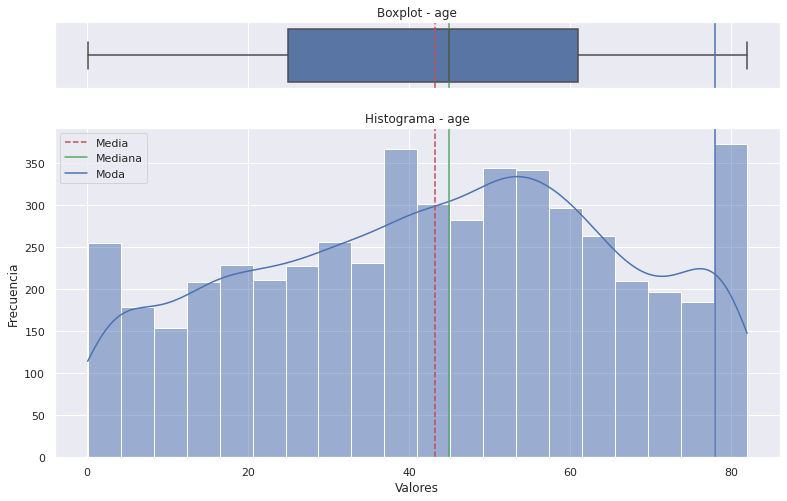


Metricas:



,age
count,5110.000000
mean,43.226614
std,22.612647
min,0.080000
25%,25.000000
50%,45.000000
75%,61.000000
max,82.000000


In [75]:
describe_num_var(dataset, 'age')

#### Hypertension

Indica si el paciente tiene hipertension o no. Es una variable categorica con los siguentes posibles valores:


Posibles Valores: 0, 1.

Histograma:


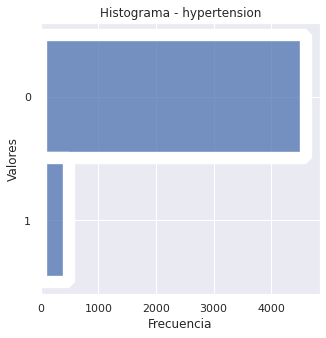


Tabla de frecuencias:



0    4612
1     498
Name: hypertension, dtype: int64

In [76]:
describe_cat_var(dataset, 'hypertension')

#### Heart Disease

Explica si el individio tiene una enfermedad cardiaca o no. Es una variable categorica con los siguentes posibles valores:


Posibles Valores: 0, 1.

Histograma:


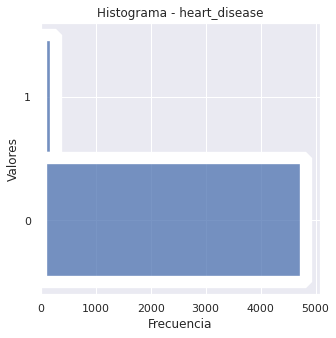


Tabla de frecuencias:



0    4834
1     276
Name: heart_disease, dtype: int64

In [77]:
describe_cat_var(dataset, 'heart_disease')

#### Ever Married

Indica si el individuo estuvo o esta casado. Es una variable categorica con los siguentes posibles valores:


Posibles Valores: Yes, No.

Histograma:


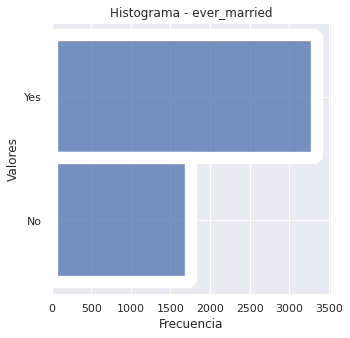


Tabla de frecuencias:



Yes    3353
No     1757
Name: ever_married, dtype: int64

In [78]:
describe_cat_var(dataset, 'ever_married')

#### Work Type

Tipo de trabajo. Es una variable categorica con los siguentes posibles valores:


Posibles Valores: Private, Self-employed, children, Govt_job, Never_worked.

Histograma:


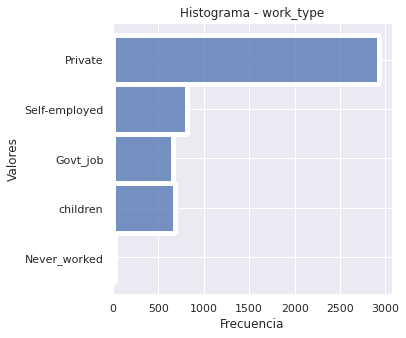


Tabla de frecuencias:



Private          2925
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: work_type, dtype: int64

In [79]:
describe_cat_var(dataset, 'work_type')

#### Residence type

Tipo de zona donde reside el invididuo. Es una variable categorica con los siguentes valores:


Posibles Valores: Urban, Rural.

Histograma:


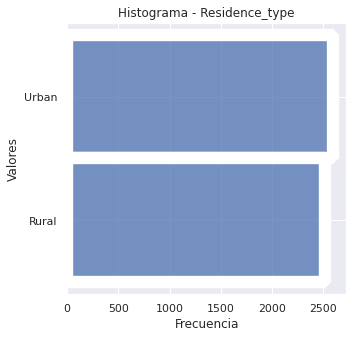


Tabla de frecuencias:



Urban    2596
Rural    2514
Name: Residence_type, dtype: int64

In [80]:
describe_cat_var(dataset, 'Residence_type')

#### AVG Glucose Level

Nivel de grucosa medio del individuo. Es una variable numerica.


Rango: (55.12, 271.74)



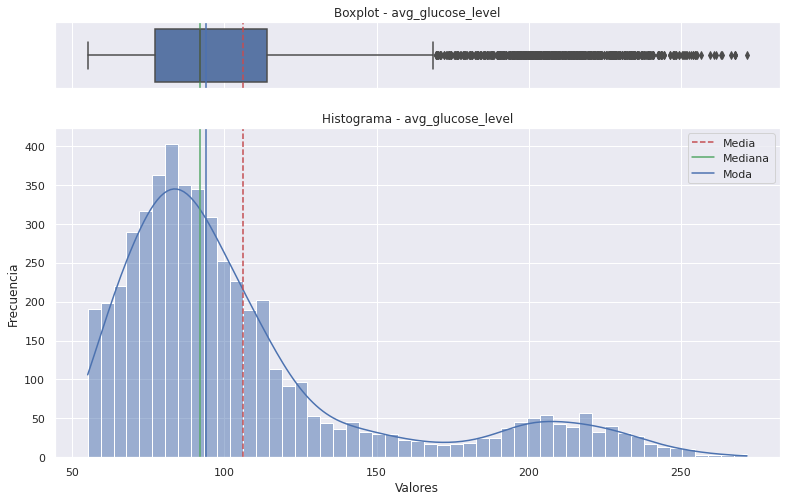


Metricas:



,avg_glucose_level
count,5110.000000
mean,106.147677
std,45.283560
min,55.120000
25%,77.245000
50%,91.885000
75%,114.090000
max,271.740000


In [81]:
describe_num_var(dataset, 'avg_glucose_level')

#### BMI

Es una variable numerica. Se refiere al incide de masa corporal del individuo. Body Mass Index (Peso / Altura^2).


Rango: (10.3, 97.6)



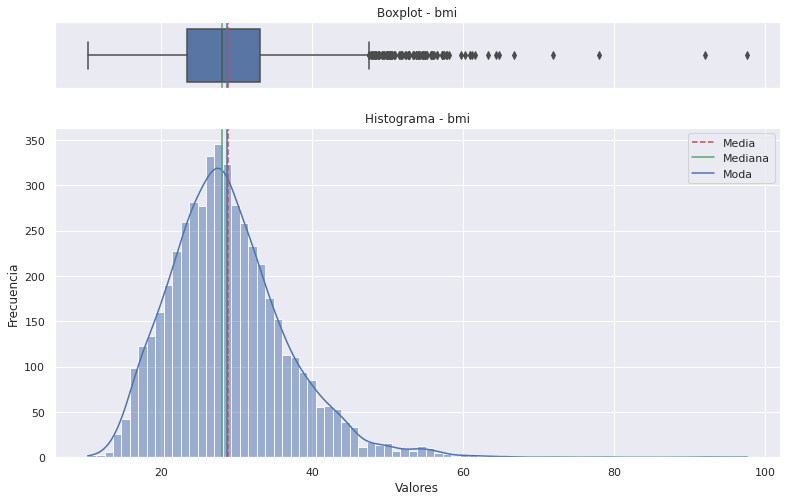


Metricas:



,bmi
count,4909.000000
mean,28.893237
std,7.854067
min,10.300000
25%,23.500000
50%,28.100000
75%,33.100000
max,97.600000


In [82]:
describe_num_var(dataset, 'bmi')

#### Smoking Status

Se refiere al nivel de fumador al que perteneces el individuo. Es una variable categorica con los siguentes valores:


Posibles Valores: never smoked, Unknown, formerly smoked, smokes.

Histograma:


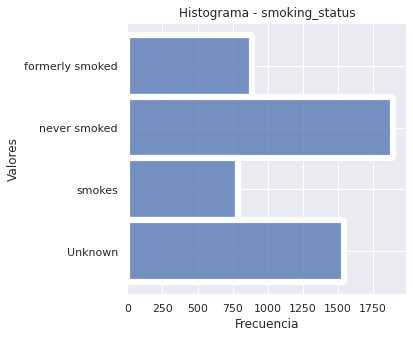


Tabla de frecuencias:



never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: smoking_status, dtype: int64

In [83]:
describe_cat_var(dataset, 'smoking_status')

#### Stroke (Accidente Cerebrovascular)

Informa si el individuo sufrio un accidente cerebrovascular o no. Es una variable categorica con los siguentes valores:


Posibles Valores: 0.0, 1.0.

Histograma:


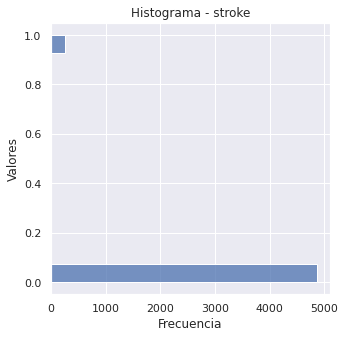


Tabla de frecuencias:



0.0    4861
1.0     249
Name: stroke, dtype: int64

In [84]:
describe_cat_var(dataset, 'stroke')

#### b) Reportar si hay valores faltantes. ¿Cuántos son y en qué atributos se encuentran? En caso de haberlos, ¿es necesario y posible asignarles un valor?

Antes de completar valores faltante vamos a separar el dataset en dos conjuntos, development y test:

In [85]:
#
# Funciones utilizadas para contruir un resumen de datos relevante de un objeto SetsGroup.
#

def missing_values_summary(df):
    result = round(df.isna().sum() * 100 / len(dataset), 2)
    result = result[result > 0]
    result = result.apply(lambda value: f'{value}%')
    return result 

def set_summary(features, target, title=None):
    if title:
        print(f'\n{title}:')
    print('- Features shape:',  features.shape)
    print('- Target shape:',     target.shape)
    print('- Target classes:')
    classes = target.value_counts(normalize=True)
    values = classes * 100

    print("\t- Clase {}: {:.2f} %".format(str(classes.index[0][0]), values.values[0]))
    print("\t- Clase {}: {:.2f} %".format(str(classes.index[1][0]), values.values[1]))

    missing = missing_values_summary(features)

    if missing.empty:
        print('- Valores faltandes en features: No hay valores faltantes!')
    else:
        print('- Valores faltandes en features: ')
        print(missing)

In [86]:
#
# Funciones utilizadas para consultar nombres de columnas o indices de las mismas.
#

def num_column_names(df):
    return df.select_dtypes(include=np.number).columns

def cat_column_names(df):
    return list(set(df.columns) - set(num_column_names(df)))

def cat_column_indexes(df):
    return [df.columns.get_loc(col_name) for col_name in cat_column_names(df)]

def unique_column_values(df, column_name): 
    return df[column_name].value_counts().index.values

def copy_columns(origin_df, target_df, names=None):
    """
    Copy n columnas desde el df origen al df destino.
    """
    if names is None:
        names = origin_df.columns

    for name in names: target_df[name] = origin_df[name]
    return target_df

In [87]:
@dataclass
class SetsGroup:
    """
    Representa a los conjuntos de train-validation y develoment-test. Utilizado como abstraccion comun
    para todos los algoritmos de esta notebook.
    """
    dev_features: pd.DataFrame
    test_features: pd.DataFrame
    dev_target: pd.DataFrame
    test_target: pd.DataFrame

    def summary(self):
        set_summary(self.dev_features, self.dev_target, title='Conjunto de entrenamiento/desarrollo')
        set_summary(self.test_features, self.test_target, title='Conjunto de validacion/test')
        self.info()

    def features(self):
        return pd.concat([self.dev_features, self.test_features])
    
    def targets(self):
        return pd.concat([self.dev_target, self.test_target])

    def dataset(self):
        return copy_columns(self.targets(), self.features())
    
    def feature_names(self):
        return self.dev_features.columns
            
    def cat_feature_names(self):
        return cat_column_names(self.dev_features)

    def cat_feature_indexes(self):
        return cat_column_indexes(self.dev_features)

    def num_feature_names(self):
        return num_column_names(self.dev_features)

    def feature_unique_values(self, column_name):
        return unique_column_values(self.features(), column_name)

    def dev_set(self):      
        return pd.concat([sets_group.dev_features,sets_group.dev_target], axis=1)

    def keep_features(self, columns):
        columns_to_remove = set(self.dev_features) - set(columns)
        return self.remove_features(columns_to_remove)
    
    def remove_features(self, columns):
        return SetsGroup(
            self.dev_features.drop(columns, axis = 1),
            self.test_features.drop(columns, axis = 1),
            self.dev_target, 
            self.test_target
        )
    
    def info(self):
        print('\nFeatures info:\n')
        self.dev_features.info()
        print('\nTarget info:\n')
        self.dev_target.info()
        
    def head(self):
        print('\nDeveopment Features:\n')
        display(self.dev_features.head())
        print('\nDeveopment Target:\n')
        display(self.dev_target.head())
        print('\Test Features:\n')
        display(self.test_features.head())
        print('\nTest Target:\n')
        display(self.test_target.head())

class DevTestSpliter:
    """
    Divide un dataset en dos conjuntos con sus pares features-target. Devuelve un objecto SetsGroup.
    """

    @staticmethod
    def split(
        dataset, 
        target_col = 'stroke', 
        test_size = 0.2,
        random_state = 1
    ):
        features = dataset.loc[:, dataset.columns != target_col]
        target   = dataset[[target_col]]

        dev_features, test_features, dev_target, test_target = train_test_split(
            features, 
            target, 
            test_size    = test_size,
            random_state = random_state,
            stratify     = target.values
        )
        return SetsGroup(dev_features, test_features, dev_target, test_target)

Dividimos el databse en dos conjuntos, development y test. Un 80% para development y un 20% para test:

In [88]:
sets_group = DevTestSpliter.split(dataset, test_size = 0.2)

sets_group.summary()


Conjunto de entrenamiento/desarrollo:
- Features shape: (4088, 11)
- Target shape: (4088, 1)
- Target classes:
	- Clase 0.0: 95.13 %
	- Clase 1.0: 4.87 %
- Valores faltandes en features: 
bmi    3.39%
dtype: object

Conjunto de validacion/test:
- Features shape: (1022, 11)
- Target shape: (1022, 1)
- Target classes:
	- Clase 0.0: 95.11 %
	- Clase 1.0: 4.89 %
- Valores faltandes en features: 
bmi    0.55%
dtype: object

Features info:

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4088 entries, 2051 to 4232
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 4088 non-null   int64  
 1   gender             4088 non-null   object 
 2   age                4088 non-null   float64
 3   hypertension       4088 non-null   object 
 4   heart_disease      4088 non-null   object 
 5   ever_married       4088 non-null   object 
 6   work_type          4088 non-null   object 
 7   Residence_typ

**Nota:** La unica variable incompleta es **BMI** y es un 3.93 + 0.55 % de valores faltantes.

Ahora completamos valores faltantes y comparamos la distribucion de la columna **BMI** antes y despues de la imputacion:

In [89]:
def impute_missing_values(df, excluded = ['id'], random_state=0):
    """
    Imputa valores faltantes exceptuando las columnas excluidas.
    """
    num_features = df.select_dtypes(include=np.number)
    num_features = num_features[set(num_features.columns) - set(excluded)]

    # Algoritmo basado en el algoritmo MICE de R
    imputer = IterativeImputer(random_state=random_state) 
    imputer.fit(num_features)

    imp_num_features = imputer.transform(num_features)

    result_df = pd.DataFrame(
        data    = imp_num_features, 
        columns = num_features.columns
    )
    for col in cat_column_names(df):
        result_df[col] = df[col].values

    return result_df



class MissingValuesImpoter:
    """
    Imputa valores sobre faltantes sobre un objeto SetsGroup, exceptuando las columnas excluidas.
    """

    def __init__(self, excluded = ['id'], random_state=0):
        self.excluded     = excluded
        self.random_state = random_state
    
    def impute(self, sets_group):
        imp_dev_features  = impute_missing_values(
            sets_group.dev_features,
            random_state = self.random_state
        )
        imp_test_features = impute_missing_values(
            sets_group.test_features,
            random_state = self.random_state
        )
        return SetsGroup(
            imp_dev_features, 
            imp_test_features, 
            sets_group.dev_target, 
            sets_group.test_target
        )


def compare_distributions(df1, df2, column):
    """
    Util para comparar dos distribuciones graficamente.
    """
    normal_size()
    sns.kdeplot(df1[column], shade=True, color="r")
    sns.kdeplot(df2[column], shade=True, color="b")

Chequeamos que se hayan completado als columnas y comparamos las distribuciones para development y test:

In [90]:
imputer = MissingValuesImpoter()

imp_sets_group = imputer.impute(sets_group)

imp_sets_group.summary()


Conjunto de entrenamiento/desarrollo:
- Features shape: (4088, 10)
- Target shape: (4088, 1)
- Target classes:
	- Clase 0.0: 95.13 %
	- Clase 1.0: 4.87 %
- Valores faltandes en features: No hay valores faltantes!

Conjunto de validacion/test:
- Features shape: (1022, 10)
- Target shape: (1022, 1)
- Target classes:
	- Clase 0.0: 95.11 %
	- Clase 1.0: 4.89 %
- Valores faltandes en features: No hay valores faltantes!

Features info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4088 entries, 0 to 4087
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   bmi                4088 non-null   float64
 1   age                4088 non-null   float64
 2   avg_glucose_level  4088 non-null   float64
 3   smoking_status     4088 non-null   object 
 4   hypertension       4088 non-null   object 
 5   gender             4088 non-null   object 
 6   heart_disease      4088 non-null   object 
 7   Residence_type     4

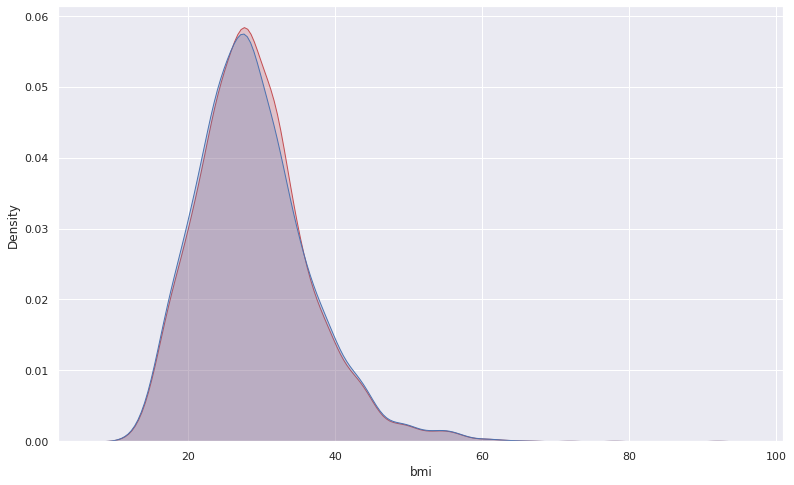

In [91]:
compare_distributions(imp_sets_group.dev_features, sets_group.dev_features, 'bmi')

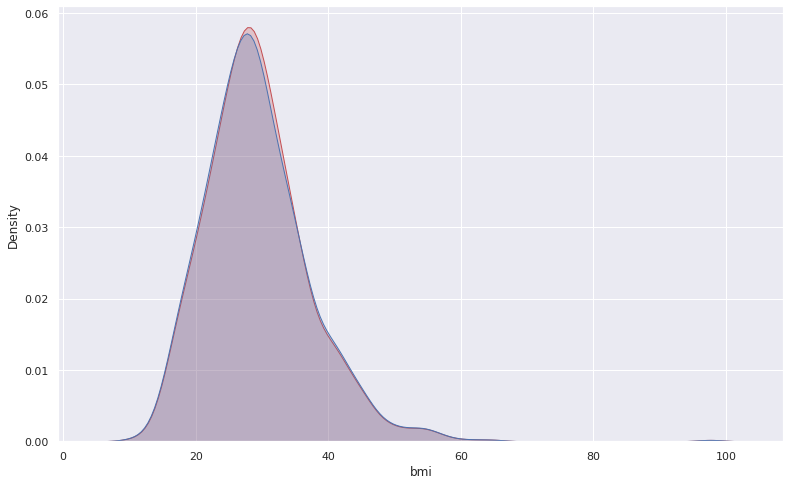

In [92]:
compare_distributions(imp_sets_group.test_features, sets_group.test_features, 'bmi')

Ahora la columna BMI esta completa.

#### c) ¿Qué variables se correlacionan más con el evento de lesión (Stroke)? Para las cuatro más correlacionadas, realizar un gráfico en el que se pueda observar la correlación entre la variable y el stroke.

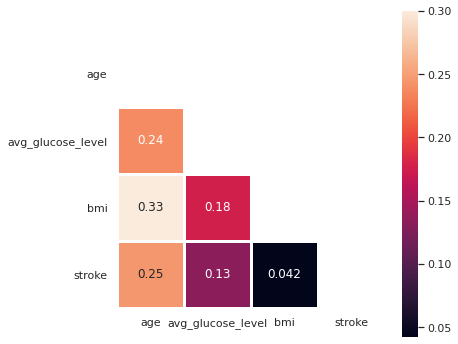

In [93]:
def heatmap(corr, resumed=True, figsize=(6, 6), vmax=.3, square=True, annot=True, linewidths=3):
    if resumed:
        mask = np.zeros_like(corr)
        mask[np.triu_indices_from(mask)] = True
    else:
        mask = None

    with sns.axes_style("white"):
        f, ax = plt.subplots(figsize=figsize)
        ax = sns.heatmap(corr, mask=mask, vmax=vmax, square=square, annot=annot, linewidths=linewidths)


tmp_dataset = dataset.drop('id', axis=1)

heatmap(tmp_dataset.corr())

Al parecer stroke tiene baja correlacion con las demas variables pero existe un nivel. El orden de mas correlacionada a menos es:

* Age (0.25)
* Hypertension, Heart Disease y AVG Glucose Level (0.13)
* BMI (0.044)

**Edad vs. stroke(Accidente cerebrovascular)**

In [94]:
def plot_var_vs_var(df, col_a, col_b):    
    df[col_a] = df[col_a].astype(int)
    df[col_b] = df[col_b].astype(int)
    sns.pairplot(df[[col_a, col_b]], height=3)
    sns.pairplot(df[[col_a, col_b]], hue=col_b, height=5)

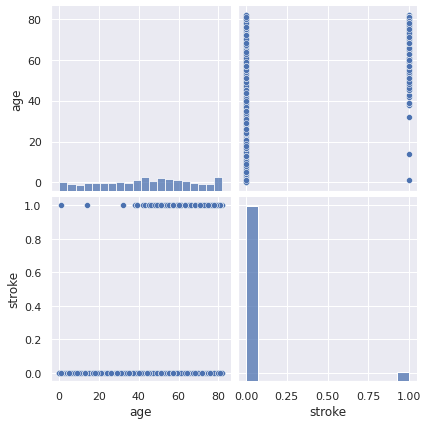

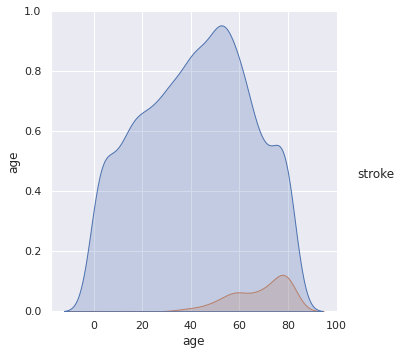

In [95]:
plot_var_vs_var(tmp_dataset, 'age','stroke')

Conclusiones:

* Ambas densidades estan solapadas.
* Para age <= 23: La probabilidad de tener un daño cereblar es practicamente nula.
* Para age > 23: La probabilidad de tener un daño cereblar es conciderable pero sigue siendo baja con relaciona a la probabilidad de no tener daño cerebral.

**Hipertensión vs daño cerebral**

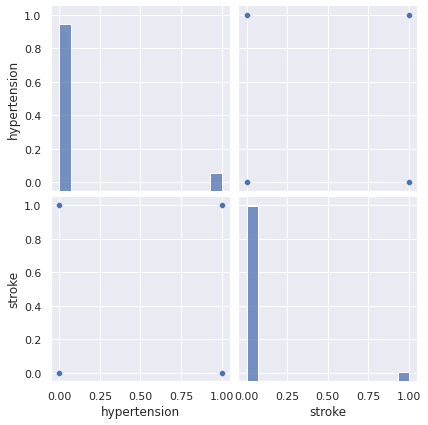

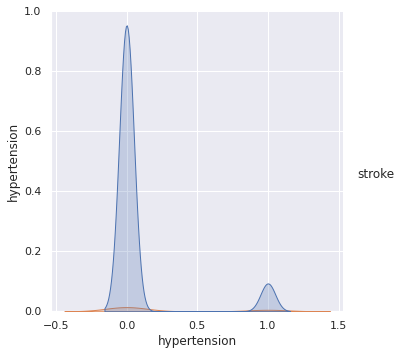

In [96]:
plot_var_vs_var(tmp_dataset, 'hypertension','stroke')

Conclusiones:
    
* Ambas densidades estan solapadas.
* -0.2 <= hypertension <= 0.2
    * P(Daño cerebral/ Nivel de hipertension) <<<< P(Daño cerebral/ Nivel de hipertension)
* 0.8 <= hypertension <= 1.2
    * P(Daño cerebral/ Nivel de hipertension) <<<< P(No Daño cerebral/ Nivel de hipertension)
* En otros valores hay una probabilidad muy baja de daño cereblar.

**Enfermedad del corazón vs daño cerebral**

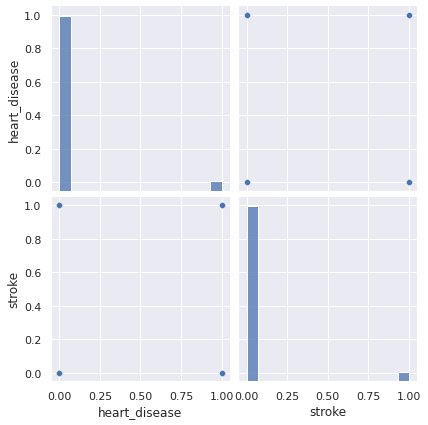

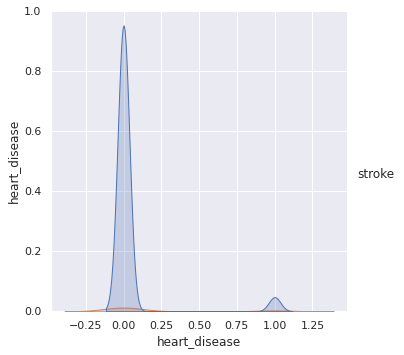

In [97]:
plot_var_vs_var(tmp_dataset, 'heart_disease','stroke')

Conclusiones:
    
* Ambas densidades estan solapadas.
* -0.2 <= heart_disease <= 0.2
    * P(Daño cerebral/ Enfermedad del corazón) <<<< P(No Daño cerebral/ Enfermedad del corazón)
* 0.8.5 <= hypertension <= 1.1
    * P(Daño cerebral/ Enfermedad del corazón) <<<< P(No Daño cerebral/ Enfermedad del corazón)
* En otros valores hay una probabilidad muy baja de daño cereblar.

**Promedio del nivel de glucosa vs daño cerebral**

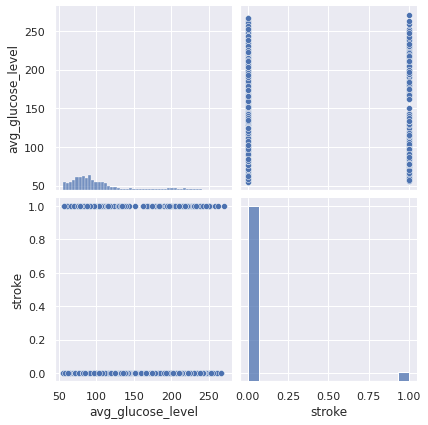

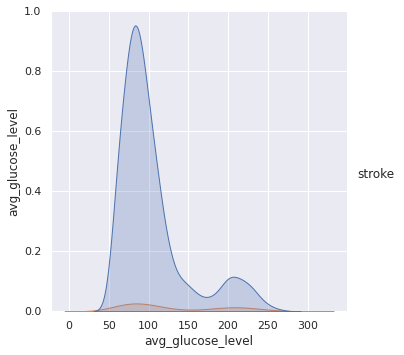

In [98]:
plot_var_vs_var(tmp_dataset, 'avg_glucose_level','stroke')

Conclusiones:
    
* Ambas densidades estan solapadas.
* - 40 <= avg_glucose_level <= 170
    * P(Daño cerebral/ nivel de glucosa) <<<< P(No Daño cerebral/ nivel de glucosa)
* 0.8.5 <= hypertension <= 1.1
    * P(Daño cerebral/ nivel de glucosa) <<<< P(No Daño cerebral/ nivel de glucosa)
* En otros valores hay una probabilidad muy baja de daño cereblar.

#### d) Se necesita saber cuáles son los indicadores que determinan más susceptibilidad a sufrir una lesión. ¿Qué atributos utilizará como variables predictoras? ¿Por qué?

Inicialmente vamos a utilizar todos los atributos. Entendemos que hay atributos que pueden ser mas importantes que otros para la clasificación. Una manera de determina esto seria post entrenamiento del modelo, el cual como resultado especifica cual es el orden de importancia de las variables para la construccion del mismo. De esta manera, podriamos quitar las variables que ya sabemos que no tiene incidencia en el modelo.

#### e) ¿Se encuentra balanceado el conjunto de datos que utilizará para desarrollar el algoritmo diseñado para contestar el punto d)? En base a lo respondido, ¿qué métricas de performance reportaría y por qué? En caso de estar desbalanceado, ¿qué estrategia de balanceo utilizaría?

In [99]:
imp_sets_group.summary()


Conjunto de entrenamiento/desarrollo:
- Features shape: (4088, 10)
- Target shape: (4088, 1)
- Target classes:
	- Clase 0.0: 95.13 %
	- Clase 1.0: 4.87 %
- Valores faltandes en features: No hay valores faltantes!

Conjunto de validacion/test:
- Features shape: (1022, 10)
- Target shape: (1022, 1)
- Target classes:
	- Clase 0.0: 95.11 %
	- Clase 1.0: 4.89 %
- Valores faltandes en features: No hay valores faltantes!

Features info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4088 entries, 0 to 4087
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   bmi                4088 non-null   float64
 1   age                4088 non-null   float64
 2   avg_glucose_level  4088 non-null   float64
 3   smoking_status     4088 non-null   object 
 4   hypertension       4088 non-null   object 
 5   gender             4088 non-null   object 
 6   heart_disease      4088 non-null   object 
 7   Residence_type     4

**Claramente esta desbalanceado** dado que es normal tener menos casos de daño cerebral.

In [100]:
class OverUnderSampler:
    """
    Se encarga de realizar un over/under sampling sobre un dataframe de features. 
    Esto nos permite balancear el dataset especificando el grado:

        - over sampling: Sobre la clase minoritaria (entre 0 y 1).
        - under sampling: Sobre la clase mayoritaria (entre 0 y 1).
    """
    def __init__(
        self,
        categorical_features, 
        random_state=None, 
        oversampling_strategy='auto', 
        undersampling_strategy='auto'
    ):
        oversampler = SMOTENC(
            categorical_features = categorical_features, 
            random_state = random_state,
            sampling_strategy = undersampling_strategy
        )
        undersampler = RandomUnderSampler(sampling_strategy = undersampling_strategy)
        self.pipeline = Pipeline(steps=[('oversampler', oversampler), ('undersampler', undersampler)])
        
    def perform(self, features, target):
        bal_features, bal_target = self.pipeline.fit_resample(features.values, target.values)
        
        # Matrix to DataFrame
        bal_features = pd.DataFrame(data = bal_features, columns = features.columns)
        bal_target   = pd.DataFrame(data = bal_target,   columns = target.columns)

        return bal_features, bal_target

In [101]:
class SetsGroupOverUnderSampler:
    """
    Utiliza el objeto OverUnderSampler para aplicar over/under sampling sobre 
    los conjuntos de features dentro de un objeto SetsGroup. 
    """
    @staticmethod
    def createFromHps(categorical_features, hps, column_formater):
        return SetsGroupOverUnderSampler(
            categorical_features   = categorical_features,
            random_state           = hps.random_state, 
            oversampling_strategy  = hps.oversampling_strategy,
            undersampling_strategy = hps.undersampling_strategy,
            column_formater        = column_formater
        )

    def __init__(
        self,
        categorical_features,
        column_formater,
        random_state = None,
        # Grado de oversampling sobre la clase minoriataria (entre 0 y 1).
        oversampling_strategy = 0.1,
        # Grado de undersampling sobre la clase mayoriataria (entre 0 y 1).
        undersampling_strategy = 1
    ):
        self.sampler = OverUnderSampler(
            categorical_features   = categorical_features,
            random_state           = random_state,      
            oversampling_strategy  = oversampling_strategy,
            undersampling_strategy = undersampling_strategy
        )
        self.column_formater       = column_formater

    def perform(self, sets_group):
        bal_dev_features, bal_dev_target = self.sampler.perform(
            sets_group.dev_features, 
            sets_group.dev_target
        )

        bal_dev_features = self.column_formater.format(bal_dev_features)
        bal_dev_target   = self.column_formater.format(bal_dev_target)

        return SetsGroup(
            bal_dev_features, 
            sets_group.test_features, 
            bal_dev_target, 
            sets_group.test_target
        )

In [102]:
sampler = SetsGroupOverUnderSampler(
    categorical_features   = imp_sets_group.cat_feature_indexes(),
    column_formater        = ColumnFormaterFactory.default(),
    oversampling_strategy  = 0.1, # Grado de oversampling sobre la clase minoriataria (entre 0 y 1).
    undersampling_strategy = 1    # Grado de undersampling sobre la clase mayoriataria (entre 0 y 1).
)

oversampled_sets_group = sampler.perform(imp_sets_group)

oversampled_sets_group.summary()


Conjunto de entrenamiento/desarrollo:
- Features shape: (7778, 10)
- Target shape: (7778, 1)
- Target classes:
	- Clase 0.0: 50.00 %
	- Clase 1.0: 50.00 %
- Valores faltandes en features: No hay valores faltantes!

Conjunto de validacion/test:
- Features shape: (1022, 10)
- Target shape: (1022, 1)
- Target classes:
	- Clase 0.0: 95.11 %
	- Clase 1.0: 4.89 %
- Valores faltandes en features: No hay valores faltantes!

Features info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7778 entries, 0 to 7777
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   bmi                7778 non-null   float64
 1   age                7778 non-null   float64
 2   avg_glucose_level  7778 non-null   float64
 3   smoking_status     7778 non-null   object 
 4   hypertension       7778 non-null   object 
 5   gender             7778 non-null   object 
 6   heart_disease      7778 non-null   object 
 7   Residence_type     

#### f) Suponiendo que es más importante detectar los casos en donde el evento ocurre. ¿Qué medida de performance utilizaría? Si utiliza Fβ-Score, ¿qué valor de β eligiría?

**Completar!**

#### g) Implementar el algoritmo introducido en el punto d) utilizando árboles de decisión. En primer lugar, se deberá separar un 20% de los datos para usarlos como conjunto de evaluación (test set). El conjunto restante (80%) es el de desarrollo y es con el que se deberá continuar haciendo el trabajo. Realizar los siguientes puntos

In [103]:
class FeatureOneHotEncoder:
    """
    Realiza un one-hot encoding sobre la columns de una dataset. Coimo resultado obtenemos otro dataset
    con una columna por cada valor posible en la columna origen y nombre igual a nombre_columna_origen_valor.
    """
    def __init__(self, all_values_df):
        self.encoder = OneHotEncoder()
        self.encoder.fit(all_values_df)

    def encode(self, df, column):
        result = pd.DataFrame(self.encoder.transform(df[[column]]).toarray())
        result.rename(columns = { name: f'{column}_{name}' for name in result.columns }, inplace=True)
        return result

Probamos realizar one.hot encoding sonbre una unica columna:

In [104]:
column = 'work_type'

encoder = FeatureOneHotEncoder(
    all_values_df = oversampled_sets_group.features()[[column]]
)

encoder.encode(
    df = oversampled_sets_group.dev_features, 
    column = column
)

,work_type_0,work_type_1,work_type_2,work_type_3,work_type_4
0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0
4,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...
7773,0.0,0.0,1.0,0.0,0.0
7774,0.0,0.0,1.0,0.0,0.0
7775,0.0,0.0,1.0,0.0,0.0
7776,0.0,0.0,1.0,0.0,0.0


In [105]:
class CategoricalFeaturesEncoder:
    """
    Se encarga de traducir los valores de features categoricos a numerico. 
    Esto es necesario ya que los arboles solo entiende features numericos.
    """

    def perform(self, sets_group):
        enc_dev_features  = sets_group.dev_features.copy()
        enc_test_features = sets_group.test_features.copy()

        for col_name in sets_group.cat_feature_names():
            encoder = FeatureOneHotEncoder(sets_group.features()[[col_name]])
            
            col_one_hot = encoder.encode(sets_group.dev_features, col_name)
            enc_dev_features = copy_columns(col_one_hot, enc_dev_features, col_one_hot.columns)     
            enc_dev_features.drop([col_name], axis=1, inplace=True)
    
            col_one_hot = encoder.encode(sets_group.test_features, col_name)
            enc_test_features = copy_columns(col_one_hot, enc_test_features, col_one_hot.columns)            
            enc_test_features.drop([col_name], axis=1, inplace=True)

        return SetsGroup(
            enc_dev_features, 
            enc_test_features, 
            sets_group.dev_target, 
            sets_group.test_target
        )

Traducimos los valores de los features categoricas a numericos:

In [106]:
encoder = CategoricalFeaturesEncoder()

encoded_sets_group = encoder.perform(oversampled_sets_group)

encoded_sets_group.summary()


Conjunto de entrenamiento/desarrollo:
- Features shape: (7778, 23)
- Target shape: (7778, 1)
- Target classes:
	- Clase 0.0: 50.00 %
	- Clase 1.0: 50.00 %
- Valores faltandes en features: No hay valores faltantes!

Conjunto de validacion/test:
- Features shape: (1022, 23)
- Target shape: (1022, 1)
- Target classes:
	- Clase 0.0: 95.11 %
	- Clase 1.0: 4.89 %
- Valores faltandes en features: No hay valores faltantes!

Features info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7778 entries, 0 to 7777
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   bmi                7778 non-null   float64
 1   age                7778 non-null   float64
 2   avg_glucose_level  7778 non-null   float64
 3   hypertension_0     7778 non-null   float64
 4   hypertension_1     7778 non-null   float64
 5   smoking_status_0   7778 non-null   float64
 6   smoking_status_1   7778 non-null   float64
 7   smoking_status_2   

In [107]:
encoded_sets_group.head()


Deveopment Features:



,bmi,age,avg_glucose_level,hypertension_0,hypertension_1,smoking_status_0,smoking_status_1,smoking_status_2,smoking_status_3,gender_0,...,heart_disease_1,Residence_type_0,Residence_type_1,ever_married_0,ever_married_1,work_type_0,work_type_1,work_type_2,work_type_3,work_type_4
0,22.4,35.0,74.55,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,23.0,19.0,73.33,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,32.1,46.0,85.35,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,31.5,66.0,106.10,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,31.0,42.0,68.19,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0



Deveopment Target:



,stroke
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0


\Test Features:



,bmi,age,avg_glucose_level,hypertension_0,hypertension_1,smoking_status_0,smoking_status_1,smoking_status_2,smoking_status_3,gender_0,...,heart_disease_1,Residence_type_0,Residence_type_1,ever_married_0,ever_married_1,work_type_0,work_type_1,work_type_2,work_type_3,work_type_4
0,18.6,20.0,102.42,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,16.1,61.0,73.36,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,24.5,61.0,60.61,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,25.8,54.0,98.44,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
4,18.1,2.0,114.02,1.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0



Test Target:



,stroke
2820,0.0
1722,0.0
3591,0.0
4305,0.0
3311,0.0


Estas son funciones complementarias para mostrar un summary de nuestro modelo:

In [108]:
def plot_features_importance(feature_importances, column_names):
    normal_size()
    plt.barh(column_names, feature_importances)
    plt.ylabel('Caracteristicas')
    plt.xlabel('Nivel de importancia')
    plt.title("Importancia de los features")
    plt.show()

def to_tree_img(tree):
    dot_data = StringIO()
    export_graphviz(
        tree, 
        out_file           = dot_data,  
        filled             = True,
        rounded            = True,
        special_characters = True
    )
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
    graph.write_png('tree.png')
    return mpimg.imread('tree.png')

def plot_tree(tree):
    sns.set(rc={'figure.figsize':(15, 8)})
    plt.title('Arbol de decisión')
    plt.grid(False)
    plt.imshow(to_tree_img(tree))
    plt.axis('off')
    plt.show()
    
def cm_plot(ax, cm, title='Matriz de confusión'):     
    sns.heatmap(
        cm, 
        ax    = ax,
        annot = True, 
        fmt   = 'g', 
        cmap  = 'Blues', 
        cbar  = False
    )
    ax.set_ylabel('Realidad')
    ax.set_xlabel('Predicciones')
    ax.set_title(title)

Definimos nuestro modelo. Este es un wrapper de un estimador:

In [109]:
class ModelFactory:
    """
    Usado para construir distintos modelos.
    """
    @staticmethod
    def create(hps):
        tree = DecisionTreeClassifier(
            criterion        = hps.criterion,
            max_depth        = hps.max_depth,
            min_samples_leaf = hps.min_samples_leaf,
            ccp_alpha        = hps.ccp_alpha,
            class_weight     = hps.class_weight,
            random_state     = hps.random_state
        )
        return Model(tree, hps)

    def create_from(tree):
        return Model(tree, hps)


class Model:
    """
    Es un wrapper de un estimador. permite simplificar el uso de un estimador abstrayéndonos de todo el codigo boilerplate 
    al momento de usar un estimador. Ademas permite visualizar todas las metricas de performace de una vez.
    """
    def __init__(self, tree, hps):
        self.tree = tree
        self.hps  = hps

    def fit(self, sets_group):
        """
        Entrena el modelo.
        """
        return self.tree.fit(
            sets_group.dev_features.values, 
            sets_group.dev_target.values
        )

    def predict(self, features):
        """
        Permite realizar una estimación.
        """
        return self.tree.predict(features.values)

    def evaluate(self, sets_group):
        """
        Evalua el modelo en los conjuntos de entrenamiento/desarrollo y validacion/test. 
        """
        train_pred  = self.predict(sets_group.dev_features)
        test_pred   = self.predict(sets_group.test_features)
        return ModelSummary(
            sets_group, 
            train_pred, 
            test_pred, 
            tree = self.tree, 
            hps  = self.hps,
            features_importance = self.tree.feature_importances_
        )

class ModelSummary:
    """
    Es el resultado de la evaluacion de un modelo. Este permite visualizar varias metricas 
    utiles para evaluar el desempeño del modelo.
    """
    def __init__(self, sets_group, train_pred, test_pred, tree, hps, features_importance):
        self.metrics = {
            'train_accuracy':              accuracy_score(sets_group.dev_target.values, train_pred),
            'train_precision':             precision_score(sets_group.dev_target.values, train_pred),
            'train_recall':                recall_score( sets_group.dev_target.values, train_pred),
            "train_f1_score":              f1_score(sets_group.dev_target.values, train_pred),
            'train_confusion_matrix':      confusion_matrix(sets_group.dev_target.values, train_pred),
            'train_classification_report': classification_report(sets_group.dev_target.values, train_pred),

            'val_accuracy':              accuracy_score(sets_group.test_target.values, test_pred),
            'val_precision':             precision_score(sets_group.test_target.values, test_pred),
            'val_recall':                recall_score(sets_group.test_target.values, test_pred),
            "val_f1_score":              f1_score(sets_group.test_target.values, test_pred),
            'val_confusion_matrix':      confusion_matrix(sets_group.test_target.values, test_pred),
            'val_classification_report': classification_report(sets_group.test_target.values, test_pred)
        }
        self.feature_names       = sets_group.dev_features.columns
        self.features_importance = features_importance
        self.tree = tree
        self.hps  = hps

        self.excluded_metics = [
            "train_confusion_matrix", 
            "val_confusion_matrix", 
            "train_classification_report",
            "val_classification_report",
        ]

    def plot_confusion_matrix(self):
        sns.set(rc={'figure.figsize':(7, 4)})
        fig = plt.figure()
        gs = fig.add_gridspec(1, 2, hspace=0.1, wspace=0.1)
        (ax1, ax2) = gs.subplots(sharex='col', sharey='row')
        cm_plot(
            ax=ax1,
            cm=self.metrics['train_confusion_matrix'],
            title='Entrenamiento'
        )
        cm_plot(
            ax=ax2,
            cm=self.metrics['val_confusion_matrix'],
            title='Validacion'
        )
        fig.suptitle('Matriz de confusión')
        plt.show()
        
    def show_feature_importace(self):
        plot_features_importance(self.features_importance, self.feature_names)

    def show_metrics(self):
        print('\nMetricas:')
        for name in self.metrics.keys():
            if name not in self.excluded_metics:
                print(f'- {name}: {self.metrics[name]*100:.2f}%')

    def show_classification_report(self):
        print('- train_classification_report:\n', self.metrics['train_classification_report'])
        print('- val_classification_report:\n', self.metrics['val_classification_report'])

    def show_hps(self):
        if self.hps:
            print('\nHiper Parametros:\n-', self.hps)

    def show(self):
        self.show_hps()
        self.show_metrics()
        self.show_classification_report()
        self.plot_confusion_matrix()
        self.show_feature_importace()
        plot_tree(self.tree)

Definimos un pipeline con todas las transformaciones que necesitamos realizar al raw dataset para preparlo para el entrenamiento: 

In [110]:
def data_transform_pipeline(data, hps):
    # Imputamos valores faltantes (MICE like)...
    imputer = MissingValuesImpoter(random_state = hps.random_state)
    data = imputer.impute(data)
    
    # Balanceamos el dataset (over/up sampling)...
    sampler = SetsGroupOverUnderSampler.createFromHps(
        data.cat_feature_indexes(), 
        hps,
        ColumnFormaterFactory.default()
    )
    data = sampler.perform(data)

    # Llevamos variables categoricas a numericas...
    endcoder = CategoricalFeaturesEncoder()
    data = endcoder.perform(data)

    return data

Funciones helper utilizadas para evaloar un modelos y mostar resultados:

In [111]:
def evaluate_model(model, sets_group):
    """
    Entrena un modelo y lo evalua en el conjunto de validacion o test. 
    Luego muestra un summary de metricas y graficos.
    """
    
    # Entrenamos el modelos...
    model.fit(sets_group)
    
    # Evaluamos el modelo sobre el conjuntos de validación.
    summary = model.evaluate(sets_group)
    
    # Mostramos el resumen de metricas...
    summary.show()

    return model

def evaluate_estimator(estimator, sets_group):
    # Creamos el model wrapper para el estimador...
    model = ModelFactory.create_from(estimator)

    return evaluate_model(model, sets_group)

Entrenamos un primer modelo:

In [112]:
@dataclass
class HiperParams:
    # Hiper parametros del modelo:
    criterion: any        = 'gini' 
    max_depth: int        = 4
    min_samples_leaf: int = 1
    ccp_alpha: float      = 0.0
    class_weight: any     = 'balanced'
    
    # Semilla usada en todos lo algoritmos.
    random_state: int     = 42 

    # Hiper parametros para over/up sampling:
    # Porcentaje de ejemplos duplicados en la calse minoritaria.
    oversampling_strategy: float = 0.1
    # Porcentaje de ejemplos removidos ne la clase mayoritaria.
    undersampling_strategy: float = 1


Conjunto de entrenamiento/desarrollo:
- Features shape: (7778, 23)
- Target shape: (7778, 1)
- Target classes:
	- Clase 0.0: 50.00 %
	- Clase 1.0: 50.00 %
- Valores faltandes en features: No hay valores faltantes!

Conjunto de validacion/test:
- Features shape: (1022, 23)
- Target shape: (1022, 1)
- Target classes:
	- Clase 0.0: 95.11 %
	- Clase 1.0: 4.89 %
- Valores faltandes en features: No hay valores faltantes!

Features info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7778 entries, 0 to 7777
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   bmi                7778 non-null   float64
 1   age                7778 non-null   float64
 2   avg_glucose_level  7778 non-null   float64
 3   hypertension_0     7778 non-null   float64
 4   hypertension_1     7778 non-null   float64
 5   smoking_status_0   7778 non-null   float64
 6   smoking_status_1   7778 non-null   float64
 7   smoking_status_2   

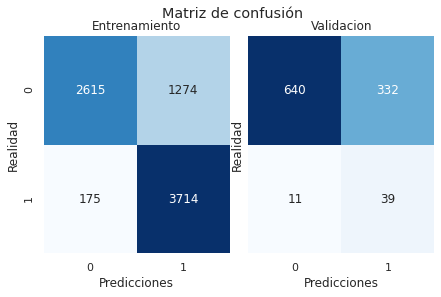

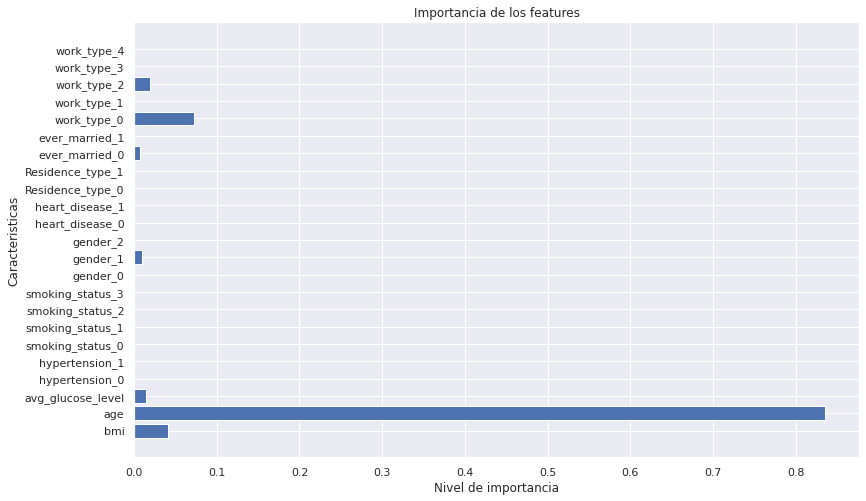

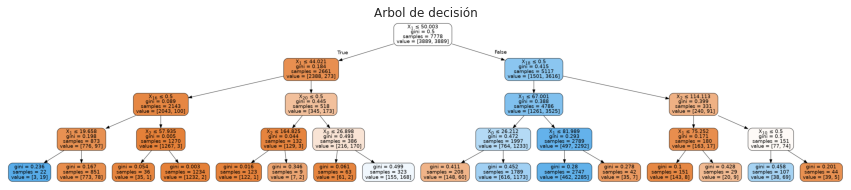

In [113]:
hiper_params = [
    # Usamos todos los valores por defecto...
    HiperParams()
]

for hps in hiper_params:
    # Pipeline de trasnformación de datos...
    data = data_transform_pipeline(sets_group, hps)

    # Resumen de estrutura de los datos...
    data.summary()

    # Creamos el modelo (Arbol de decisión)...
    model = ModelFactory.create(hps)
    
    evaluate_model(model, data)

#### g.1) Armar conjuntos de entrenamiento y validación con proporción 80-20 del conjunto de desarrollo de forma aleatoria. Usar 50 semillas distintas y realizar un gráfico de caja y bigotes que muestre cómo varía la métrica elegida en c) en esas 50 particiones distintas.

In [114]:
class MetricsComparePlot:
    """
    Acumula un log de metricas para luego graficar un box plot comparativo.
    """
    def __init__(self):
        self.accs = []
        self.precisions = []
        self.recalls = []
        self.f1s = []

    def add(self, y_val,y_pred_val):
        self.accs.append(accuracy_score(y_val,y_pred_val))
        self.precisions.append(precision_score(y_val,y_pred_val))
        self.recalls.append(recall_score(y_val,y_pred_val))
        self.f1s.append(f1_score(y_val,y_pred_val))

    def plot(self):
        all_metrics = self.accs + self.precisions + self.recalls + self.f1s
        metric_labels = ['Accuracy']*len(self.accs) + ['Precision']*len(self.precisions) + ['Recall']*len(self.recalls) + ['F1 Score']*len(self.f1s)
        sns.set_context('talk')
        plt.figure(figsize=(15,8))
        sns.boxplot(metric_labels, all_metrics)
        plt.show()

Rearmamos el dataset de dev (feat + tgt) y vuelvemos a correr train/test split, ya que el primero separó dev + val:

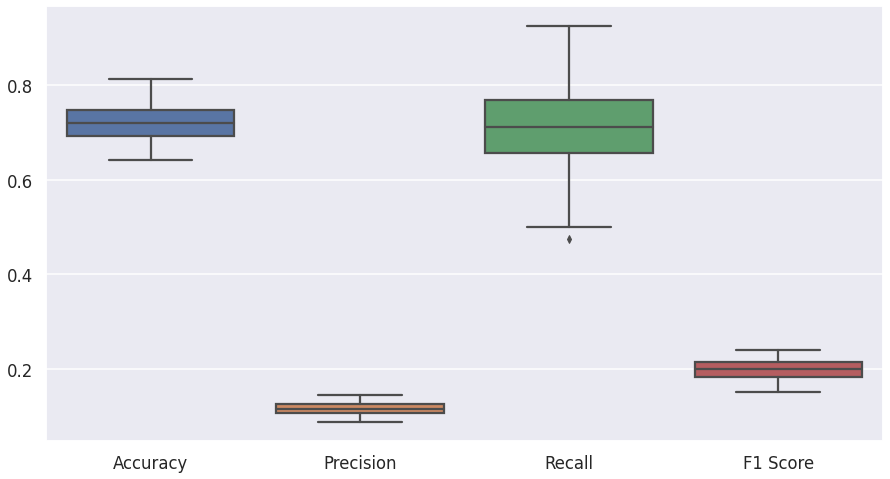

In [115]:
dev_concat = sets_group.dev_set()

n_seeds   = 50
test_size = 0.2
plotter   = MetricsComparePlot()

# De los hiperparametros por defecto quedas fijos...
hps = HiperParams()
    
for seed in range(n_seeds):
    sets_group_dev = DevTestSpliter.split(
        dev_concat, 
        test_size = test_size, 
        random_state = seed
    )

    encoded_sets_group_dev = data_transform_pipeline(sets_group_dev, hps)

    arbol = ModelFactory.create(hps)
    arbol = arbol.fit(encoded_sets_group_dev)
    y_pred_val = arbol.predict(encoded_sets_group_dev.test_features)

    plotter.add(encoded_sets_group_dev.test_target, y_pred_val)

plotter.plot()

#### g.2) Usar validación cruzada de 50 iteraciones (50-fold cross validation). Realizar un gráfico de caja y bigotes que muestre cómo varía la métrica elegida en esas 50 particiones distintas.

In [116]:
def search_best_model(sets_group, params_grid, n_splits, n_iter):
    """
    Se ocupa de buscar el mejor estimador para una grilla de hiper parametros.
    """
    print('\nRandom Search Hiper-params:', params_grid)

    scoring = make_scorer(f1_score)
    # scoring = make_scorer(fbeta_score, beta=0.1)

    randomcv = RandomizedSearchCV(
        estimator           = DecisionTreeClassifier(),
        param_distributions = params_grid,
        scoring             = scoring,
        cv                  = StratifiedKFold(n_splits=n_splits),
        n_iter              = n_iter,
        return_train_score  = True
    )
    randomcv.fit(
        sets_group.dev_features.values,
        sets_group.dev_target.values
    )
    
    random_cv_results = pd.DataFrame(randomcv.cv_results_)
    print('Models Count:', random_cv_results.shape[0])

    return randomcv

In [118]:
n_splits = 20

hps = HiperParams()

encoded_sets_group_dev = data_transform_pipeline(sets_group_dev, hps)

encoded_sets_group_dev.summary()

randomcv_sin_poda = search_best_model(
    encoded_sets_group_dev,
    params_grid = {
        'criterion': ['gini'],
        'max_depth': [None],
        'min_samples_leaf': [1]
    }, 
    n_splits = n_splits,
    n_iter = 10
)


Conjunto de entrenamiento/desarrollo:
- Features shape: (6222, 23)
- Target shape: (6222, 1)
- Target classes:
	- Clase 0.0: 50.00 %
	- Clase 1.0: 50.00 %
- Valores faltandes en features: No hay valores faltantes!

Conjunto de validacion/test:
- Features shape: (818, 23)
- Target shape: (818, 1)
- Target classes:
	- Clase 0.0: 95.11 %
	- Clase 1.0: 4.89 %
- Valores faltandes en features: No hay valores faltantes!

Features info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6222 entries, 0 to 6221
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   bmi                6222 non-null   float64
 1   age                6222 non-null   float64
 2   avg_glucose_level  6222 non-null   float64
 3   hypertension_0     6222 non-null   float64
 4   hypertension_1     6222 non-null   float64
 5   smoking_status_0   6222 non-null   float64
 6   smoking_status_1   6222 non-null   float64
 7   smoking_status_2   62

In [119]:
random_cv_results = pd.DataFrame(randomcv_sin_poda.cv_results_)
random_cv_results[random_cv_results.params == randomcv_sin_poda.best_params_]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_leaf,param_max_depth,param_criterion,params,split0_test_score,split1_test_score,...,split12_train_score,split13_train_score,split14_train_score,split15_train_score,split16_train_score,split17_train_score,split18_train_score,split19_train_score,mean_train_score,std_train_score
0,0.015776,0.000295,0.000559,0.000011,1,None,gini,"{'min_samples_leaf': 1, 'max_depth': None, 'cr...",0.92163,0.88959,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0


<AxesSubplot:>

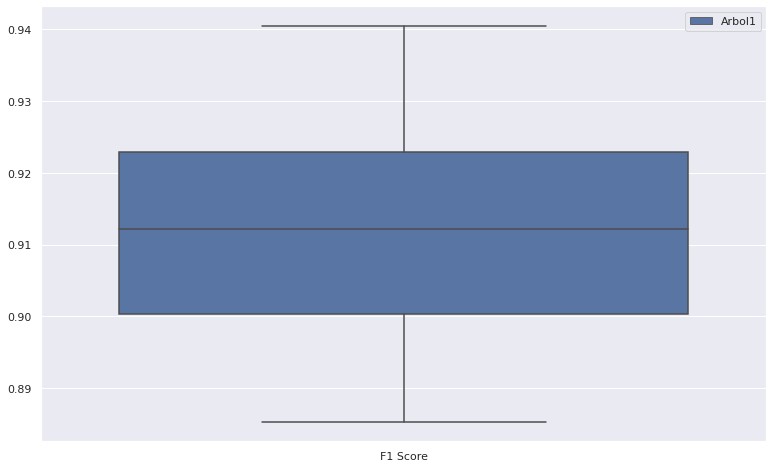

In [120]:
metric_labels = []
metric_labels = ['F1 Score']*n_splits

accs_kfold = []
for x in range(0,n_splits):
  col = 'split' + str(x) + '_test_score'
  accs_kfold.append(random_cv_results[col].values[0])

hue = []
hue = ['Arbol1']*n_splits
sns.set_context('talk')
normal_size()
sns.boxplot(metric_labels,accs_kfold,hue=hue)

Puedo generar FPR y TPR con funcion roc pero hacemos la funcion iterativa sobre los thresholds para ver paso a paso como evolucionan numericamente los valores. Vemos optimo en un threshold entre 0.34 y 0.56 la principal problematica en la definicion del threshold optimo en este caso es la cantidad de TP con los que disponemos (40) que hace que la metria "pegue saltos" con mas datos, o un oversampleado mas agresivo, podriamos llegar a lograr un detalle mas fino:

In [121]:
def perf_measure(y_actual, y_hat):
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(y_hat)): 
        if y_actual[i]==y_hat[i]==1:
           TP += 1
        if y_hat[i]==1 and y_actual[i]!=y_hat[i]:
           FP += 1
        if y_actual[i]==y_hat[i]==0:
           TN += 1
        if y_hat[i]==0 and y_actual[i]!=y_hat[i]:
           FN += 1

    return(TP, FP, TN, FN)

In [122]:
class TableAccumulator:
    def __init__(self, columns):
        self.results = pd.DataFrame(columns=columns)

    def add(self, values):
        row = {col_name: values[index] for index, col_name in enumerate(self.results.columns)}
        self.results = self.results.append(row, ignore_index=True) 

    def show(self): 
        pd.set_option('display.max_rows', self.results.shape[0]+1)
        display(self.results)

In [140]:
model = ModelFactory.create(randomcv_sin_poda.best_estimator_)
tree = model.fit(encoded_sets_group_dev)

y_hat  = tree.predict_proba(encoded_sets_group_dev.test_features)[:, 1]
y_true = encoded_sets_group_dev.test_target.stroke.values

fpr, tpr, thresholds = roc_curve(y_true, y_hat)

fpl = []
tpl = []
results = TableAccumulator(['Threshold', 'TP', 'FN', 'TPR / Recal', 'Precision'])

for x in range(0, 101, 1):
    x = x/100
    pred = [1 if y >= x else 0 for y in y_hat]
  
    TP, FP, TN, FN = perf_measure(y_true, pred) 

    if (TP + FP) != 0:
        results.add([x, TP, FN, TP/(TP+FN), TP/(TP+FP)])
    else:
        results.add([x, TP, FN, TP/(TP+FN), None])

    fpl.append(FP/(FP+TN))
    tpl.append(TP/(TP+FN))

results.show()

,Threshold,TP,FN,TPR / Recal,Precision
0,0.00,40.0,0.0,1.0,0.048900
1,0.01,8.0,32.0,0.2,0.109589
2,0.02,8.0,32.0,0.2,0.109589
3,0.03,8.0,32.0,0.2,0.109589
4,0.04,8.0,32.0,0.2,0.109589
5,0.05,8.0,32.0,0.2,0.109589
6,0.06,8.0,32.0,0.2,0.109589
7,0.07,8.0,32.0,0.2,0.109589
8,0.08,8.0,32.0,0.2,0.109589
9,0.09,8.0,32.0,0.2,0.109589


Visualizamos graficamente lo enunciado arriba, el "codo" formado entre 0.34 y 0.56:

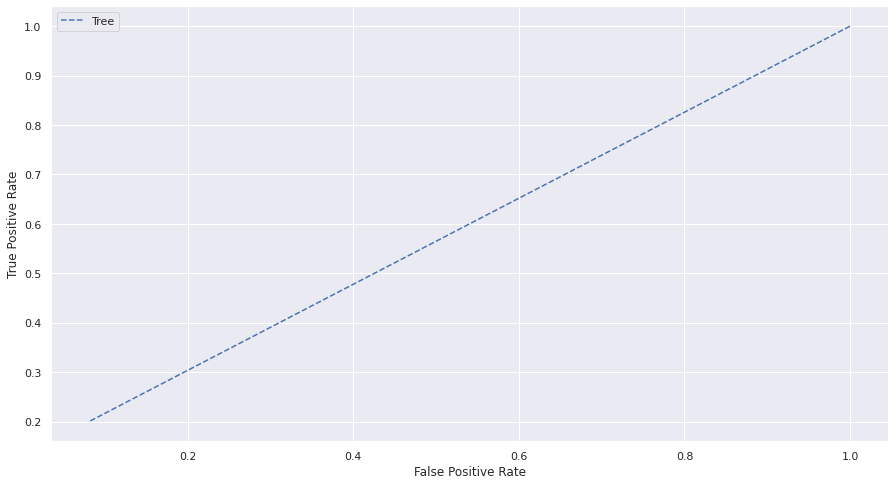

In [139]:
plt.plot(fpl, tpl, linestyle='--', label='Tree')

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# show the legend
plt.legend()

# show the plot
plt.show()

#### h) Graficar el árbol de decisión con mejor performance encontrado en el punto g2). Analizar el árbol de decisión armado (atributos elegidos y decisiones evaluadas).


Hiper Parametros:
- HiperParams(criterion='gini', max_depth=4, min_samples_leaf=1, ccp_alpha=0.0, class_weight='balanced', random_state=42, oversampling_strategy=0.1, undersampling_strategy=1)

Metricas:
- train_accuracy: 100.00%
- train_precision: 100.00%
- train_recall: 100.00%
- train_f1_score: 100.00%
- val_accuracy: 88.63%
- val_precision: 9.23%
- val_recall: 15.00%
- val_f1_score: 11.43%
- train_classification_report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      3111
         1.0       1.00      1.00      1.00      3111

    accuracy                           1.00      6222
   macro avg       1.00      1.00      1.00      6222
weighted avg       1.00      1.00      1.00      6222

- val_classification_report:
               precision    recall  f1-score   support

         0.0       0.95      0.92      0.94       778
         1.0       0.09      0.15      0.11        40

    accuracy                           0.89      

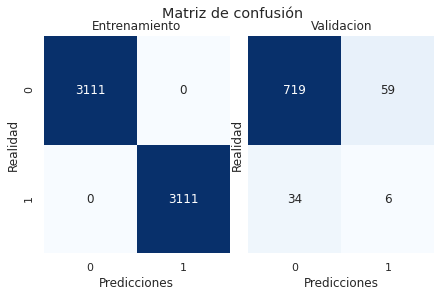

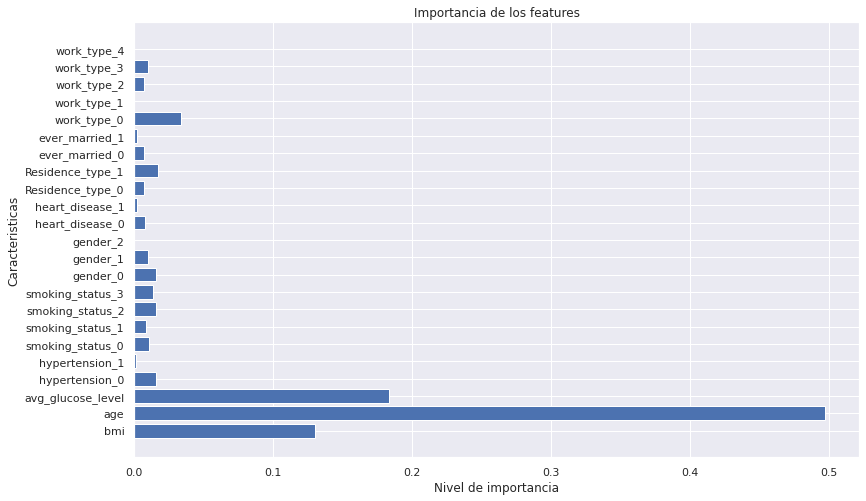

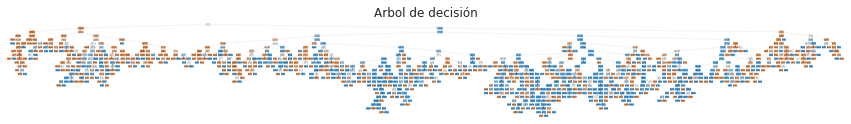

In [125]:
evaluate_estimator(
    estimator  = randomcv_sin_poda.best_estimator_,
    sets_group = encoded_sets_group_dev
)

#### i) Usando validación cruzada de 10 iteraciones (10-fold cross validation), probar distintos valores de α del algoritmo de poda mínima de complejidad de costos (algoritmo de poda de sklearn). Hacer gráficos de la performance en validación y entrenamiento en función del α. Explicar cómo varía la profundidad de los árboles al realizar la poda con distintos valores de α.

In [194]:
def to_params_grid(hiper_params):
    params_grid = {}
    for name in hiper_params.keys():
        params_grid[name] = [hiper_params[name]]
    return params_grid

Tomamos como parametros **fijos** todos los hiperparametro del el mejor modelo entrado en el punto anterior y agregamos **ccp_alpha** para buscar el valor que mejor performe la metrica seleccioanda:

In [226]:
def to_dataframe(randomcv_result): return pd.DataFrame(randomcv_result.cv_results_)

def plot_metrics(df, x_metric, y_metrics, title='', y_label=''):
    df = df.sort_values([x_metric], ascending=[True])
    normal_size()

    for y_metric in y_metrics:
        plt.plot(df[x_metric], df[y_metric],  linestyle='-', marker='o', label=y_metric)
    
    plt.legend()
    plt.xlabel(x_metric)
    plt.ylabel(y_label)
    plt.title(title)
    plt.show()

In [227]:
params_grid = to_params_grid(randomcv_sin_poda.best_params_)
params_grid['ccp_alpha'] = np.linspace(0.2, 0.01, 100)

randomcv_con_poda = search_best_model(
    encoded_sets_group_dev,
    params_grid = params_grid, 
    n_splits    = 10,
    n_iter      = 10
)


Random Search Hiper-params: {'min_samples_leaf': [1], 'max_depth': [None], 'criterion': ['gini'], 'ccp_alpha': array([0.2       , 0.19808081, 0.19616162, 0.19424242, 0.19232323,
       0.19040404, 0.18848485, 0.18656566, 0.18464646, 0.18272727,
       0.18080808, 0.17888889, 0.1769697 , 0.17505051, 0.17313131,
       0.17121212, 0.16929293, 0.16737374, 0.16545455, 0.16353535,
       0.16161616, 0.15969697, 0.15777778, 0.15585859, 0.15393939,
       0.1520202 , 0.15010101, 0.14818182, 0.14626263, 0.14434343,
       0.14242424, 0.14050505, 0.13858586, 0.13666667, 0.13474747,
       0.13282828, 0.13090909, 0.1289899 , 0.12707071, 0.12515152,
       0.12323232, 0.12131313, 0.11939394, 0.11747475, 0.11555556,
       0.11363636, 0.11171717, 0.10979798, 0.10787879, 0.1059596 ,
       0.1040404 , 0.10212121, 0.10020202, 0.09828283, 0.09636364,
       0.09444444, 0.09252525, 0.09060606, 0.08868687, 0.08676768,
       0.08484848, 0.08292929, 0.0810101 , 0.07909091, 0.07717172,
       0.07525253

In [230]:
metrics = to_dataframe(randomcv_con_poda)

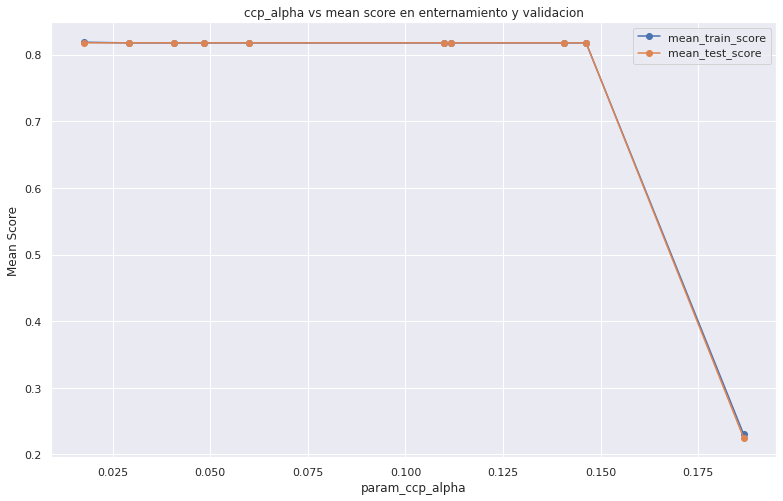

In [231]:
plot_metrics(
    metrics, 
    x_metric='param_ccp_alpha', 
    y_metrics=['mean_train_score','mean_test_score'],
    title = 'ccp_alpha vs mean score en entrenamiento y validacion',
    y_label = 'Mean Score'
)

In [ ]:
#plot_metrics(
#    metrics, 
#    x_metric='param_ccp_alpha', 
#    y_metrics=['param_ccp_alpha'],
#    title = 'ccp_alpha vs tree deep',
#    y_label = 'Tree Deep'
#)

#### j) Evaluar en el conjunto de evaluación, el árbol correspondiente al α que maximice la performance en el conjunto de validación. Comparar con el caso sin poda (α=0)

**Modelo con poda:**


Hiper Parametros:
- HiperParams(criterion='gini', max_depth=4, min_samples_leaf=1, ccp_alpha=0.0, class_weight='balanced', random_state=42, oversampling_strategy=0.1, undersampling_strategy=1)

Metricas:
- train_accuracy: 79.38%
- train_precision: 73.28%
- train_recall: 92.48%
- train_f1_score: 81.77%
- val_accuracy: 68.34%
- val_precision: 11.31%
- val_recall: 80.00%
- val_f1_score: 19.81%
- train_classification_report:
               precision    recall  f1-score   support

         0.0       0.90      0.66      0.76      3111
         1.0       0.73      0.92      0.82      3111

    accuracy                           0.79      6222
   macro avg       0.82      0.79      0.79      6222
weighted avg       0.82      0.79      0.79      6222

- val_classification_report:
               precision    recall  f1-score   support

         0.0       0.99      0.68      0.80       778
         1.0       0.11      0.80      0.20        40

    accuracy                           0.68       81

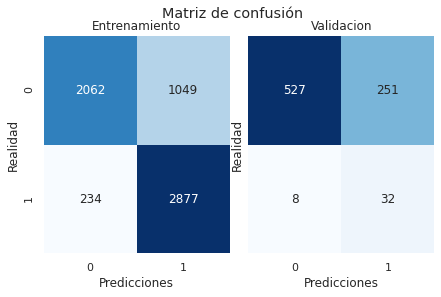

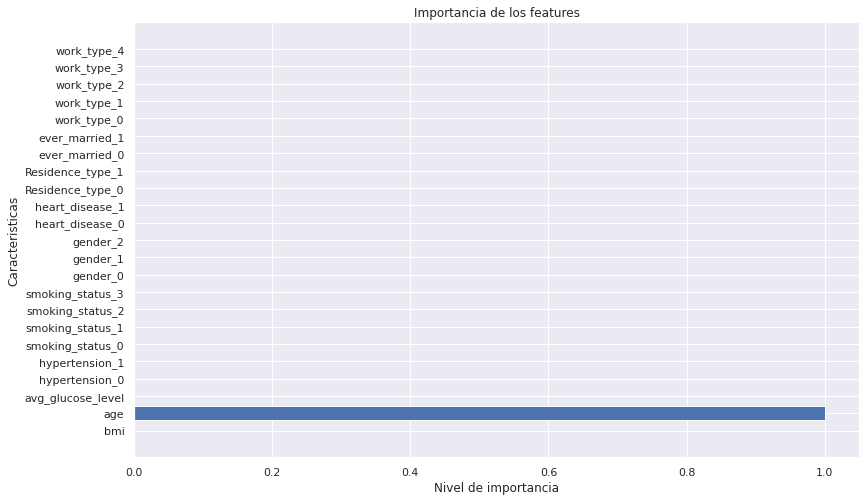

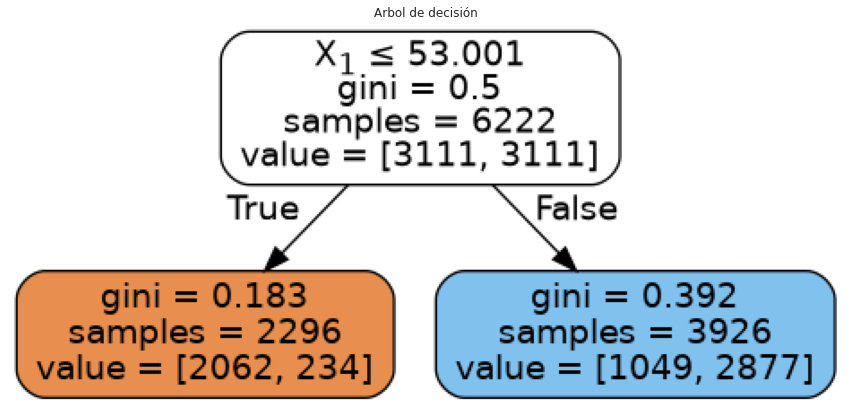

In [232]:
trained_best_model = evaluate_estimator(
    estimator  = randomcv_con_poda.best_estimator_,
    sets_group = encoded_sets_group_dev
)

**Modelo sin poda**:


Hiper Parametros:
- HiperParams(criterion='gini', max_depth=4, min_samples_leaf=1, ccp_alpha=0.0, class_weight='balanced', random_state=42, oversampling_strategy=0.1, undersampling_strategy=1)

Metricas:
- train_accuracy: 100.00%
- train_precision: 100.00%
- train_recall: 100.00%
- train_f1_score: 100.00%
- val_accuracy: 88.02%
- val_precision: 10.81%
- val_recall: 20.00%
- val_f1_score: 14.04%
- train_classification_report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      3111
         1.0       1.00      1.00      1.00      3111

    accuracy                           1.00      6222
   macro avg       1.00      1.00      1.00      6222
weighted avg       1.00      1.00      1.00      6222

- val_classification_report:
               precision    recall  f1-score   support

         0.0       0.96      0.92      0.94       778
         1.0       0.11      0.20      0.14        40

    accuracy                           0.88     

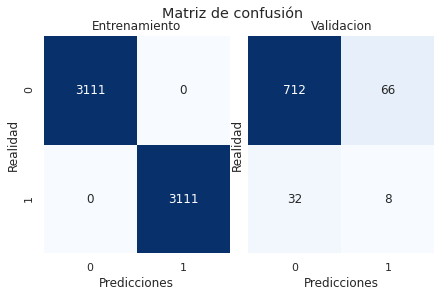

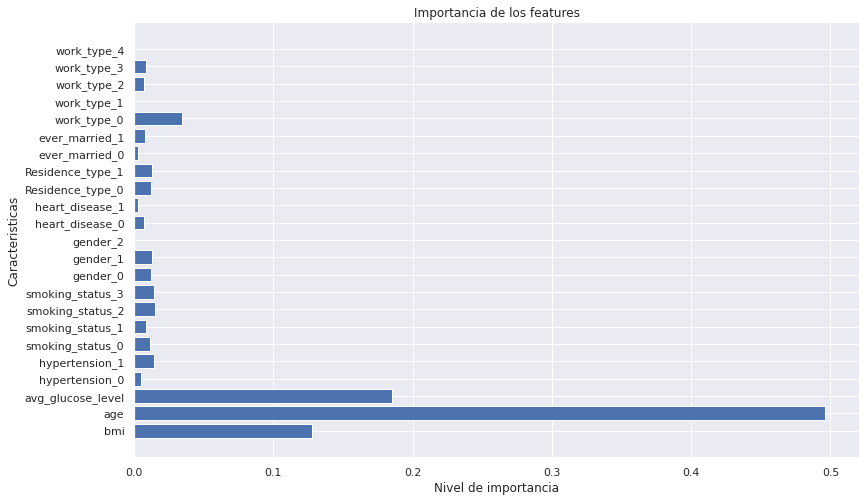

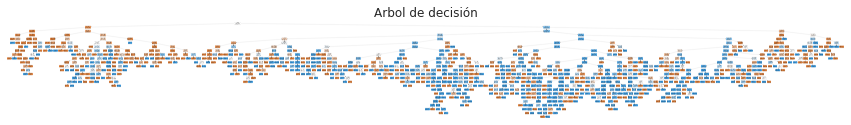

In [129]:
evaluate_estimator(
    estimator  = randomcv_sin_poda.best_estimator_,
    sets_group = encoded_sets_group_dev
)

#### k) Para el árbol sin poda, obtener la importancia de los descriptores usando la técnica de eliminación recursiva. Reentrenar el árbol usando sólo los 3 descriptores más importantes. Comparar la performance en el conjunto de prueba.

In [130]:
class BestFeaturesSelector:
    """
    Se encarga de encontrar de encontrar y rankear los mejores features de desarrollo dentro objeto SetsGroup.
    """
    def __init__(
        self, 
        estimator,
        folds_count            = 10,
        min_features_to_select = 3,
        step                   = 1,
        scoring                =  make_scorer(f1_score)
    ):
        self.selector = RFECV(
            estimator = estimator,
            step      = step, 
            cv        = StratifiedKFold(folds_count),
            scoring   = scoring,
            # Numero minimo de features
            min_features_to_select = min_features_to_select
        )
        self.min_features_to_select = min_features_to_select

    def perform(self, set_group):
        self.selector.fit(set_group.dev_features, set_group.dev_target)
        return BestFeaturesSelectorSummary(
            self.selector, 
            self.min_features_to_select,
            set_group
        )

def postions(values, equal_to):
    """
    Devuelve las posiciones en el array para los valores que sea igaules a equal_to.
    """
    return [index for index, value in enumerate(values) if value == equal_to]

class BestFeaturesSelectorSummary:
    """
    Es el resultado de realizar una selección de features con el objeto BestFeaturesSelector.
    Este contiene el resultado de este analisis ademas de metricas a modo de summary.
    """
    def __init__(self, selector, min_features_to_select, set_group): 
        self.selector = selector
        self.min_features_to_select = min_features_to_select
        self.set_group = set_group
    
    def plot(self):
        print("Numero optimo de caracteristicas: %d\n" % self.selector.n_features_)
        print("Mejores caracteristicas: %s\n" % self.best_feature_names())
        normal_size()
        plt.figure()
        plt.xlabel("Cantidad de caracteristicas")
        plt.ylabel("Metricas usada para cross validation")
        plt.plot(
            range(self.min_features_to_select,
            len(self.selector.grid_scores_) + self.min_features_to_select),
            self.selector.grid_scores_
        )
        plt.show()
    
    def best_features_index(self):
        return postions(self.selector.ranking_, equal_to=1)
    
    def best_feature_names(self):
        return self.set_group.feature_names()[self.best_features_index()]

**Modelo sin poda usando los conjuntos TRAIN + VAL**

Numero optimo de caracteristicas: 16

Mejores caracteristicas: Index(['bmi', 'age', 'avg_glucose_level', 'hypertension_0', 'smoking_status_0',
       'smoking_status_1', 'smoking_status_2', 'smoking_status_3', 'gender_0',
       'gender_1', 'heart_disease_0', 'Residence_type_0', 'Residence_type_1',
       'ever_married_0', 'work_type_0', 'work_type_2'],
      dtype='object')



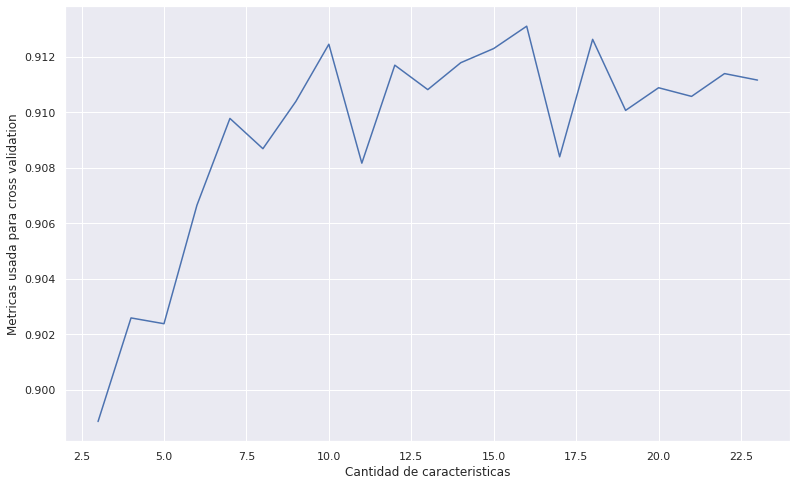

In [131]:
selector = BestFeaturesSelector(
    estimator   = randomcv_sin_poda.best_estimator_,
    folds_count = 10,
    min_features_to_select = 3
)

summary = selector.perform(encoded_sets_group_dev)

summary.plot()

Nos quedamos unicamente con los features mas importantes:

In [132]:
sets_group = encoded_sets_group_dev.keep_features(summary.best_feature_names())
print(sets_group.feature_names())

Index(['bmi', 'age', 'avg_glucose_level', 'hypertension_0', 'smoking_status_0',
       'smoking_status_1', 'smoking_status_2', 'smoking_status_3', 'gender_0',
       'gender_1', 'heart_disease_0', 'Residence_type_0', 'Residence_type_1',
       'ever_married_0', 'work_type_0', 'work_type_2'],
      dtype='object')


Entrenamos:


Hiper Parametros:
- HiperParams(criterion='gini', max_depth=4, min_samples_leaf=1, ccp_alpha=0.0, class_weight='balanced', random_state=42, oversampling_strategy=0.1, undersampling_strategy=1)

Metricas:
- train_accuracy: 100.00%
- train_precision: 100.00%
- train_recall: 100.00%
- train_f1_score: 100.00%
- val_accuracy: 88.14%
- val_precision: 12.00%
- val_recall: 22.50%
- val_f1_score: 15.65%
- train_classification_report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      3111
         1.0       1.00      1.00      1.00      3111

    accuracy                           1.00      6222
   macro avg       1.00      1.00      1.00      6222
weighted avg       1.00      1.00      1.00      6222

- val_classification_report:
               precision    recall  f1-score   support

         0.0       0.96      0.92      0.94       778
         1.0       0.12      0.23      0.16        40

    accuracy                           0.88     

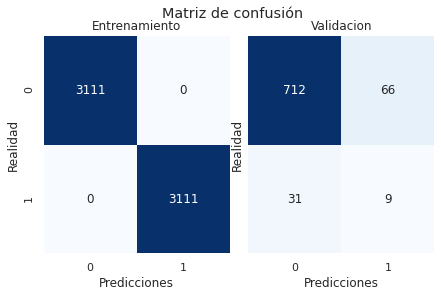

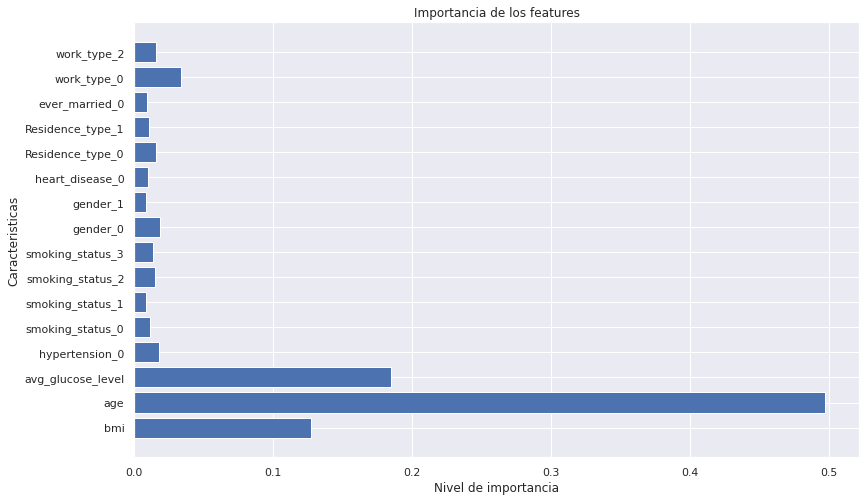

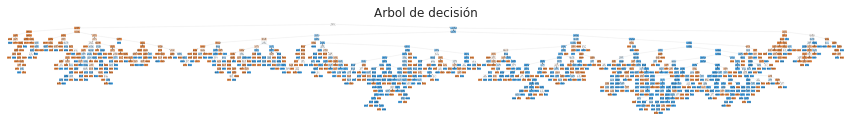

In [133]:
evaluate_estimator(
    estimator  = randomcv_sin_poda.best_estimator_,
    sets_group = sets_group
)

**Modelo sin poda usando los conjuntos DEVELOPMENT + TEST**

Numero optimo de caracteristicas: 17

Mejores caracteristicas: Index(['bmi', 'age', 'avg_glucose_level', 'hypertension_1', 'smoking_status_0',
       'smoking_status_1', 'smoking_status_2', 'smoking_status_3', 'gender_0',
       'gender_1', 'heart_disease_0', 'heart_disease_1', 'Residence_type_0',
       'Residence_type_1', 'ever_married_0', 'work_type_0', 'work_type_2'],
      dtype='object')



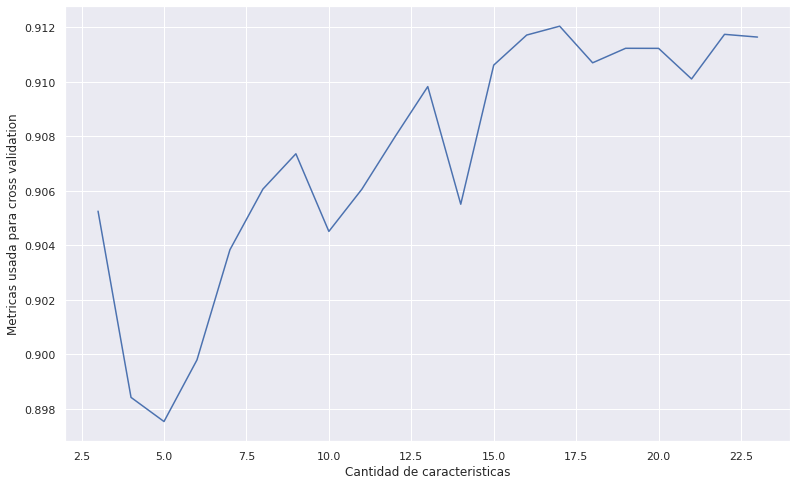

In [134]:
selector = BestFeaturesSelector(
    estimator   = randomcv_sin_poda.best_estimator_,
    folds_count = 10
)

summary = selector.perform(encoded_sets_group)

summary.plot()

Nos quedamos unicamente con los features mas importantes:

In [135]:
sets_group = encoded_sets_group.keep_features(summary.best_feature_names())
print(sets_group.feature_names())

Index(['bmi', 'age', 'avg_glucose_level', 'hypertension_1', 'smoking_status_0',
       'smoking_status_1', 'smoking_status_2', 'smoking_status_3', 'gender_0',
       'gender_1', 'heart_disease_0', 'heart_disease_1', 'Residence_type_0',
       'Residence_type_1', 'ever_married_0', 'work_type_0', 'work_type_2'],
      dtype='object')


Entrenamos:


Hiper Parametros:
- HiperParams(criterion='gini', max_depth=4, min_samples_leaf=1, ccp_alpha=0.0, class_weight='balanced', random_state=42, oversampling_strategy=0.1, undersampling_strategy=1)

Metricas:
- train_accuracy: 100.00%
- train_precision: 100.00%
- train_recall: 100.00%
- train_f1_score: 100.00%
- val_accuracy: 86.79%
- val_precision: 13.04%
- val_recall: 30.00%
- val_f1_score: 18.18%
- train_classification_report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      3889
         1.0       1.00      1.00      1.00      3889

    accuracy                           1.00      7778
   macro avg       1.00      1.00      1.00      7778
weighted avg       1.00      1.00      1.00      7778

- val_classification_report:
               precision    recall  f1-score   support

         0.0       0.96      0.90      0.93       972
         1.0       0.13      0.30      0.18        50

    accuracy                           0.87     

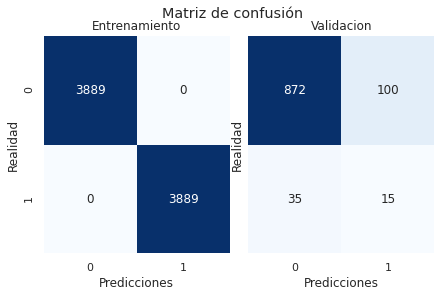

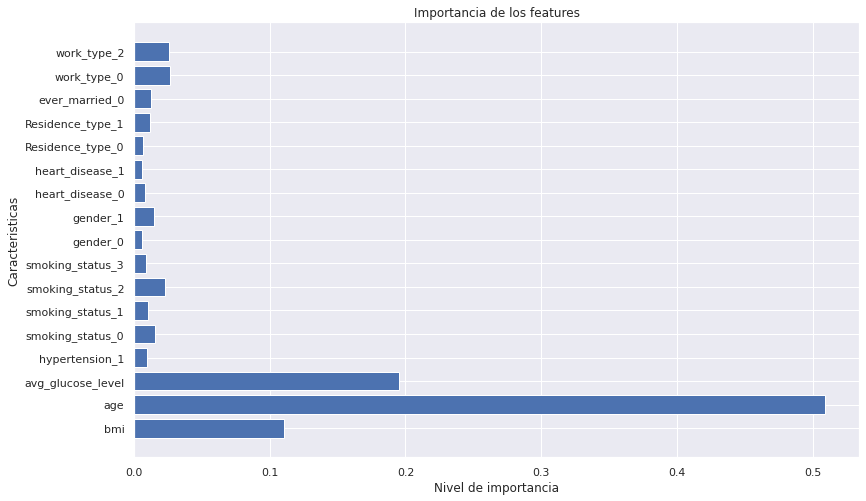

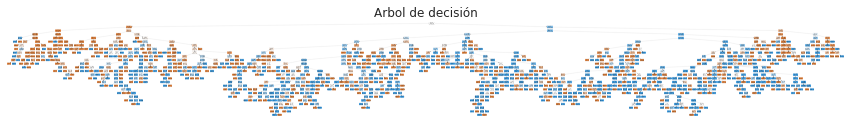

In [136]:
evaluate_estimator(
    estimator  = randomcv_sin_poda.best_estimator_,
    sets_group = sets_group
)